In [1]:
import yahooquery as yq
import yfinance as yf
from pandas_datareader import data as pdr
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


In [2]:
# sc = yq.Screener()
# data = sc.get_screeners('all_cryptocurrencies_us', count = 250)
# crypto_dict = data['all_cryptocurrencies_us']['quotes']
# tickers = [d['symbol'] for d in crypto_dict]
# start_ = '2019-03-01'
# tickers[:5]
# end_ = '2021-12-31'
# for t in tickers:
#     try:
#         df = pdr.get_data_yahoo(t,start = start_, end = end_)
#         df.to_csv(f"data/{t}.csv")
#         print(f'{t} is collected')
#     except:
#         print(f'no data {t}')

In [3]:
file_list = os.listdir('data')
tickers = [file_name[:-4] for file_name in file_list] #확장자 제거

In [97]:
def get_price_data(tickers):
    date_range = pd.date_range(start="2019-02-28",end="2021-12-31")
    price_df = pd.DataFrame()
    for t in tickers:
        df = pd.read_csv(f'data/{t}.csv')
        if df.shape[0] >= len(date_range): #3년간의 데이터
            adj_price = pd.Series(data = df['Adj Close'])
            price_df[t] = adj_price
    price_df.index = date_range
    return price_df

def get_mdd(df):
    draw_down = (df / df.max(axis = 0)) - 1
    mdd = (draw_down.min() * 100).round(2)
    return mdd

def get_geomean(df):
    df = df + 1
    day_counts = df.shape[0]
    pct_prod = df.cumprod(axis=0).iloc[-1]
    pct_mean = pct_prod ** (1 / day_counts) - 1
    return pct_mean

price_df = get_price_data(tickers)
mdd = get_mdd(price_df)
pct_df = price_df.pct_change()
geo_mean = get_geomean(pct_df)

In [98]:
def check_retun(day_change):
    seed = 1000
    total_return = seed * ((day_change + 1) ** len(price_df))
    return total_return
    
avg_profit = check_retun(geo_mean.mean())
max_profit = check_retun(geo_mean.max())
print(f"avg: {avg_profit:.2f}, max: {max_profit:.2f}")

avg: 4386.56, max: 591992.91


평균적으로 약 4.3배 상승

Text(0.5, 1.0, 'MDD is -99.93')

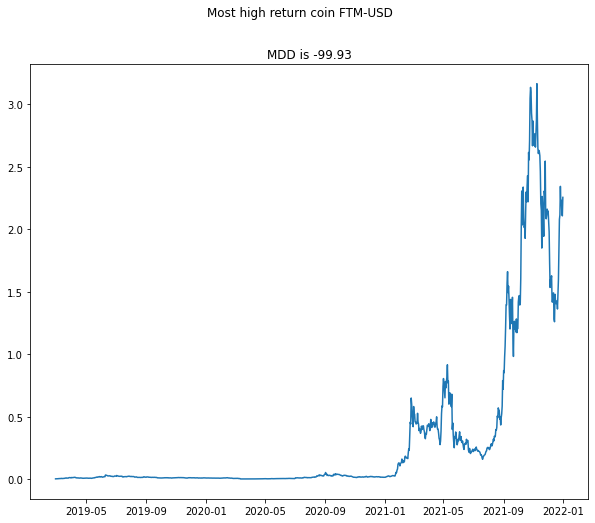

In [6]:
plt.figure(figsize=(10,8))
max_coin = geo_mean[geo_mean.max() == geo_mean].index
plt.plot(price_df[max_coin])
plt.suptitle(f"Most high return coin {max_coin[0]}")
plt.title(f'MDD is {mdd[max_coin][0]}')
# plt.legend()

In [7]:
mdd.mean()

-94.21490066225167

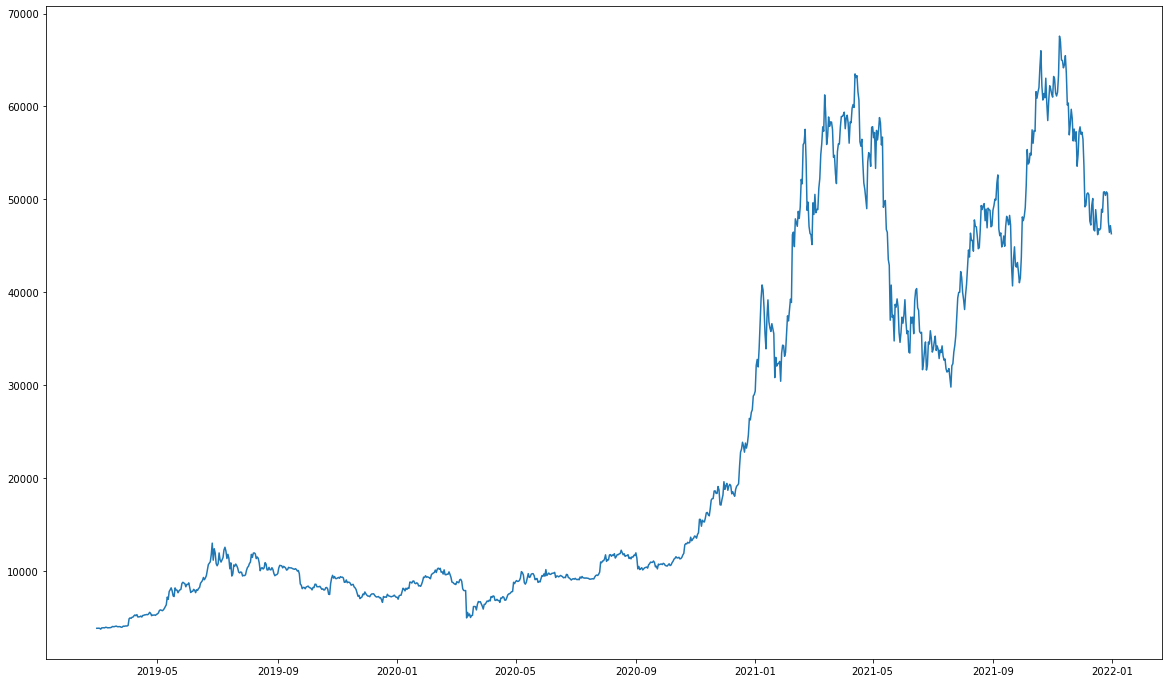

In [119]:
plt.figure(figsize=(20,12))
plt.plot(price_df['BTC-USD'])

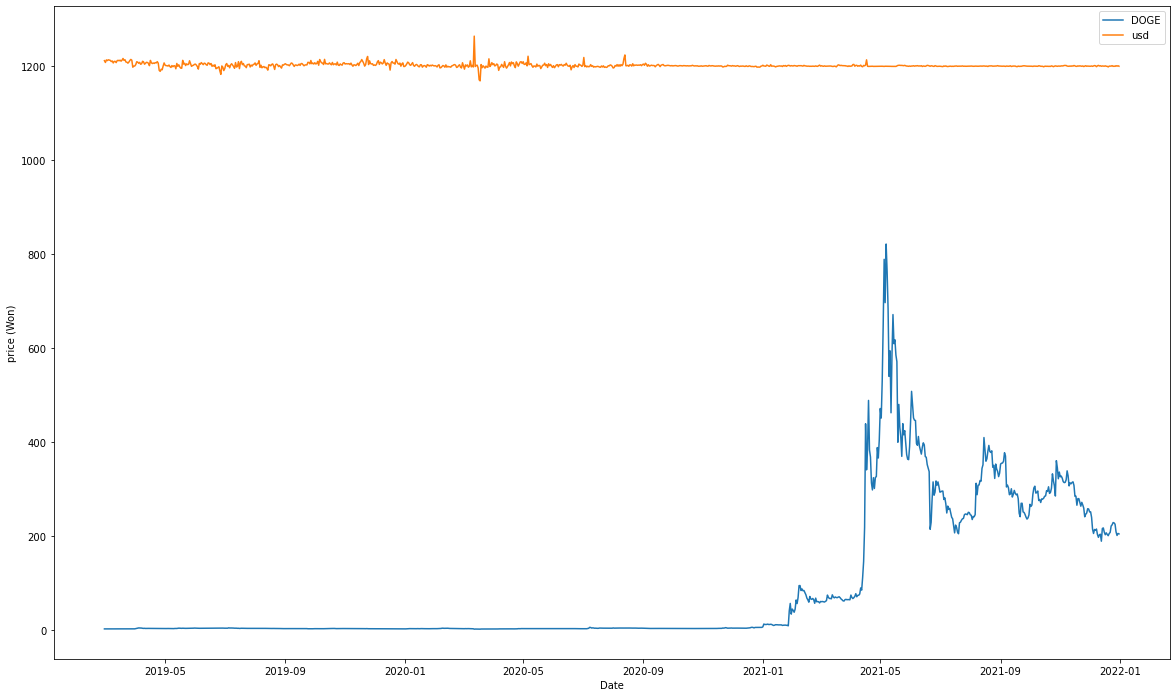

In [8]:
doge = price_df['DOGE-USD']
usd = price_df['USDT-USD']
plt.figure(figsize=(20,12))
plt.plot(doge*1200,label='DOGE')
plt.plot(usd*1200,label ='usd')
plt.xlabel('Date')
plt.ylabel('price (Won)')
plt.legend()

실상 4개를 제외하곤 전부 공격적인 코인, 3일에 한번 리밸런싱을 실시 그외의 전략들은 전부 vaa와 흡사. <br>
* 공격자산: stable 코인 4개를 제외한 전부
* 방어자산: stable 코인

In [9]:
defensive_coins = mdd[:3].index
aggresive_coins = mdd[4:].index

In [99]:
def get_momentum(asset):
    def calc_momentum(gap):
        momentum = np.zeros(asset.shape[0])
        for i in range(asset.shape[0]):
            if i < gap:
                momentum[i] = asset[i]
            else:
                momentum[i] = get_geomean(asset[i - gap: i])
        return momentum
    moment_3d = calc_momentum(3)
    moment_6d = calc_momentum(6)
    moment_9d = calc_momentum(9)
    momentum = moment_3d * 4 + moment_6d * 2 + moment_9d
    return momentum
    
# pct_df = price_df.pct_change()
moment_df = pct_df.apply(get_momentum)

In [100]:
moment_df

,USDT-USD,PIVX-USD,ZEN-USD,GLM-USD,GAS-USD,STRAX-USD,TRX-USD,ZIL-USD,ICX-USD,FTM-USD,...,VET-USD,IOTX-USD,SNX-USD,DAG-USD,BTG-USD,CRO-USD,THETA-USD,ERG-USD,NMR-USD,STMX-USD
2019-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-01,-0.022170,0.177486,-0.135735,0.238798,0.147954,0.070646,-0.041354,0.049419,0.085880,0.264637,...,0.001523,0.262833,-1.341927,0.189034,0.023032,-0.042822,-0.206895,3.193134,0.243867,-0.002552
2019-03-02,0.031619,-0.043602,0.183072,0.037716,-0.027005,-0.009086,-0.232783,0.000406,-0.289367,-0.088541,...,-0.117250,0.000000,-0.234761,0.457371,-0.079343,0.006715,0.021514,-0.540054,0.073709,0.002553
2019-03-03,-0.001767,0.070279,-0.163891,0.018462,-0.000021,-0.000406,-0.080634,-0.034504,-0.030966,0.064152,...,-0.065976,0.050968,-0.443200,0.117247,-0.063744,0.012269,-0.242713,0.253382,0.231848,0.059060
2019-03-04,0.004350,0.119681,-0.135287,-0.057786,-0.136037,-0.144899,-0.036706,-0.127692,-0.173000,-0.010340,...,-0.176337,0.087315,-0.481093,-0.028636,-0.331603,-0.046499,-0.304430,-0.578270,0.019016,0.196618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.000531,0.096533,0.011742,0.105444,0.078180,0.033502,0.002426,0.183637,0.132263,0.569545,...,0.101932,0.210051,0.130698,0.529683,0.049900,0.164633,0.344731,0.036077,0.038389,0.085798
2021-12-28,-0.001854,0.132976,0.039681,0.063403,0.068860,0.116437,0.010936,0.230772,0.153236,0.256257,...,0.148729,0.167609,0.245213,0.258640,0.022709,0.067682,0.330541,-0.017368,0.044481,0.067345
2021-12-29,0.002069,0.018082,-0.168134,-0.100194,-0.111294,-0.083754,-0.081716,0.099527,0.298356,0.238245,...,-0.089509,-0.043579,0.027667,0.031404,-0.102376,-0.141828,0.089493,-0.061289,-0.025537,-0.143979
2021-12-30,-0.000091,-0.068658,-0.222946,-0.256129,-0.180622,-0.201732,-0.112564,0.127583,-0.105399,-0.029853,...,-0.212533,-0.197814,-0.207826,-0.096645,-0.164299,-0.194823,-0.118001,-0.103163,-0.139784,-0.225361


비트,이더, 바이낸스, 카르다노,리플의 모멘텀이 전부 음의 수익률이면 테더로 도망친다.

In [101]:
def select_asset(row):
    canaria = ['BTC-USD','BNB-USD','XRP-USD','ADA-USD']
    canaria_momentum = row[canaria]
    defensive_momentum = row.loc[defensive_coins]
    aggresive_momentum = row.loc[aggresive_coins]
    if (canaria_momentum > 0).all():
        selected = aggresive_momentum[aggresive_momentum == max(aggresive_momentum)].index.tolist()
    else:
        selected = defensive_momentum[defensive_momentum == max(defensive_momentum)].index.tolist()
    if selected:
        return selected[0]
    

selected_asset = moment_df.T.apply(select_asset)

In [102]:
selected_asset

2019-02-28        None
2019-03-01     ERG-USD
2019-03-02     ZEN-USD
2019-03-03    PIVX-USD
2019-03-04    PIVX-USD
                ...   
2021-12-27    PIVX-USD
2021-12-28    VERI-USD
2021-12-29    PIVX-USD
2021-12-30    USDT-USD
2021-12-31    USDT-USD
Freq: D, Length: 1038, dtype: object

In [103]:
selected_asset[selected_asset.isin(defensive_coins)]

2019-03-02     ZEN-USD
2019-03-03    PIVX-USD
2019-03-04    PIVX-USD
2019-03-09    USDT-USD
2019-03-10    PIVX-USD
                ...   
2021-12-25     ZEN-USD
2021-12-27    PIVX-USD
2021-12-29    PIVX-USD
2021-12-30    USDT-USD
2021-12-31    USDT-USD
Length: 714, dtype: object

In [114]:
res_df = pd.DataFrame(columns = ['Change','Asset'])
change = []
assets = []
for i,v in zip(pct_df.index[2:], selected_asset[1:-1]):
    change.append(pct_df.loc[i,v])
    assets.append(v)
res_df['Change'] = change
res_df['Asset'] = assets
res_df.index = pct_df[2:].index
res_df


,Change,Asset
2019-03-02,-0.077151,ERG-USD
2019-03-03,-0.057405,ZEN-USD
2019-03-04,0.024819,PIVX-USD
2019-03-05,0.006415,PIVX-USD
2019-03-06,0.043318,META-USD
...,...,...
2021-12-27,-0.068612,FLUX-USD
2021-12-28,-0.064942,PIVX-USD
2021-12-29,-0.089814,VERI-USD
2021-12-30,0.017135,PIVX-USD


In [115]:
seed = 1000
profit = []
for v in res_df['Change']:    
    seed = seed + seed * (v / 100)
    profit.append(np.round(seed,2))
res_df['Profit'] = profit
res_df


,Change,Asset,Profit
2019-03-02,-0.077151,ERG-USD,999.23
2019-03-03,-0.057405,ZEN-USD,998.65
2019-03-04,0.024819,PIVX-USD,998.90
2019-03-05,0.006415,PIVX-USD,998.97
2019-03-06,0.043318,META-USD,999.40
...,...,...,...
2021-12-27,-0.068612,FLUX-USD,1123.09
2021-12-28,-0.064942,PIVX-USD,1122.36
2021-12-29,-0.089814,VERI-USD,1121.36
2021-12-30,0.017135,PIVX-USD,1121.55


In [106]:
(res_df['Change'] < 0).sum()

532

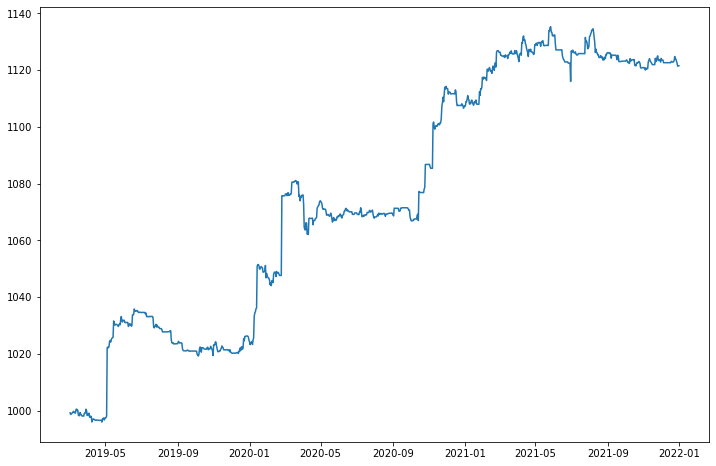

In [117]:
plt.figure(figsize=(12,8))
plt.plot(res_df['Profit'])